## ECON470 Homework 3-1
Author: Sarina Tan

In [1]:
# Importing the libraries 
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from tabulate import tabulate
from statsmodels.formula.api import ols
from causalinference import CausalModel
from sklearn.neighbors import NearestNeighbors
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')

1. Present a bar graph showing the proportion of states with a change in their cigarette tax in each year from 1970 to 1985.

In [2]:
# Load data
df = pd.read_csv("/Users/sarinatan/Desktop/HLTH470hw3/data/output/TaxBurden_Data.csv")
# Focus only on years 1970-1985
df = df[(df['Year'] >= 1970) & (df['Year'] <= 1985)]
# Sort data
df = df.sort_values(by=['state', 'Year'])

In [3]:
df['tax_change'] = df.groupby('state')['tax_state'].diff().notnull() & (df.groupby('state')['tax_state'].diff() != 0)

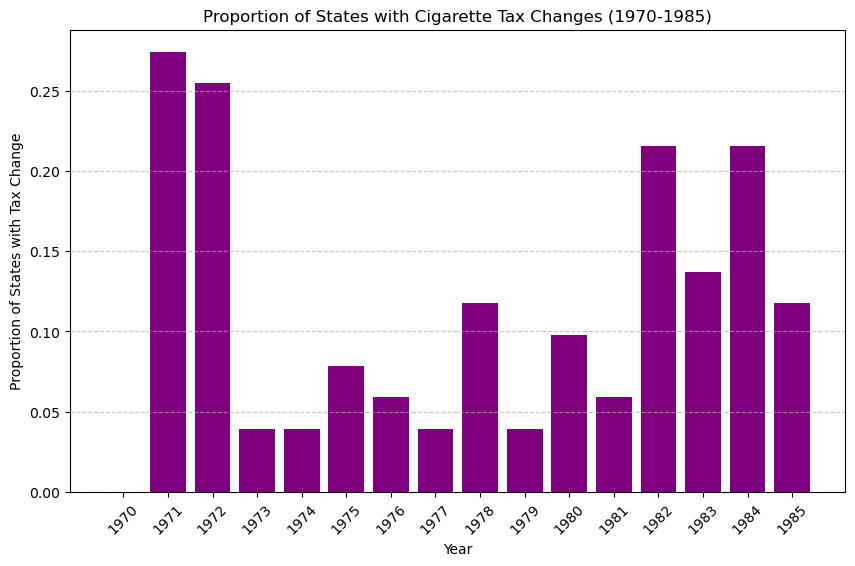

In [4]:
# Total number of states per year
states_per_year = df.groupby('Year')['state'].nunique()

# Number of states with a tax change each year
states_with_change_per_year = df[df['tax_change']].groupby('Year')['state'].nunique()

# Proportion of states with a tax change
proportion_with_change = (states_with_change_per_year / states_per_year).fillna(0).reset_index()
proportion_with_change.columns = ['Year', 'Proportion']

# Prepare graph
plt.figure(figsize=(10,6))
plt.bar(proportion_with_change['Year'], proportion_with_change['Proportion'], color='purple')
plt.title('Proportion of States with Cigarette Tax Changes (1970-1985)')
plt.xlabel('Year')
plt.ylabel('Proportion of States with Tax Change')
plt.xticks(proportion_with_change['Year'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

2. Plot on a single graph the average tax (in 2012 dollars) on cigarettes and the average price of a pack of cigarettes from 1970 to 2018.

In [5]:
# Filter for years 1970 to 2018
df = df[(df['Year'] >= 1970) & (df['Year'] <= 2018)]

# Use CPI to adjust to 2012 dollars
# Assuming 2012 CPI = 230 (You should check the exact CPI value for 2012 from your dataset if available)
df['cost_per_pack_2012'] = df['cost_per_pack'] * (230 / df['index'])
df['tax_state_2012'] = df['tax_state'] * (230 / df['index'])

# Group by year and compute average across all states
annual_avg = df.groupby('Year').agg({
    'cost_per_pack_2012': 'mean',
    'tax_state_2012': 'mean'
}).reset_index()

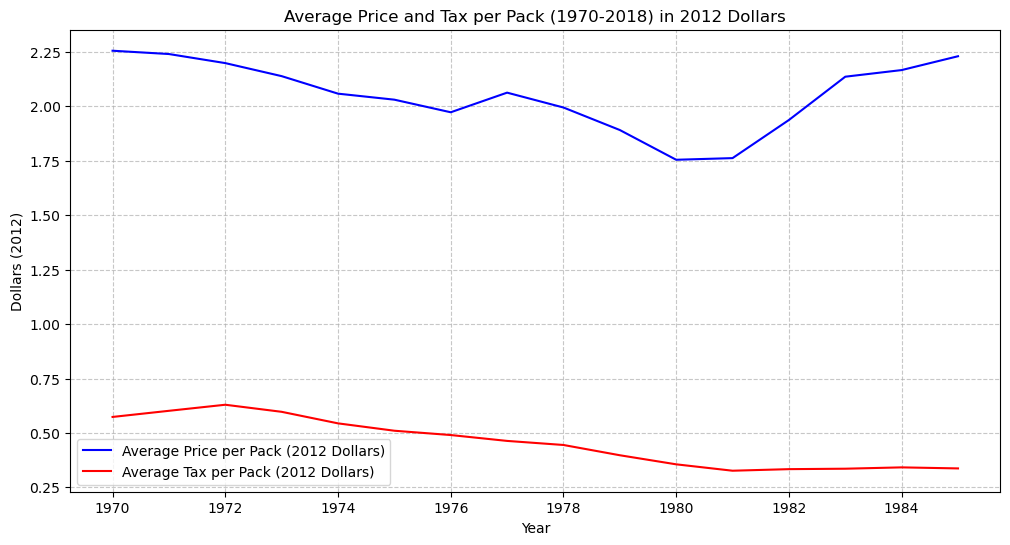

In [7]:
# Plot
plt.figure(figsize=(12, 6))

plt.plot(annual_avg['Year'], annual_avg['cost_per_pack_2012'], label='Average Price per Pack (2012 Dollars)', color='blue')
plt.plot(annual_avg['Year'], annual_avg['tax_state_2012'], label='Average Tax per Pack (2012 Dollars)', color='red')

plt.title('Average Price and Tax per Pack (1970-2018) in 2012 Dollars')
plt.xlabel('Year')
plt.ylabel('Dollars (2012)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

3. Identify the 5 states with the highest increases in cigarette prices (in dollars) over the time period. Plot the average number of packs sold per capita for those states from 1970 to 2018.

In [9]:
# Identify price change over time per state
price_change = df.groupby('state')['cost_per_pack'].agg(['first', 'last']).reset_index()
price_change['price_increase'] = price_change['last'] - price_change['first']

# Get top 5 states with highest price increases
top5_states = price_change.sort_values('price_increase', ascending=False).head(5)['state']

print("Top 5 states with highest cigarette price increases in cigarette prices in dollars:")
print(top5_states)

# Filter dataset to only those states
top5_df = df[df['state'].isin(top5_states)]

# Group by year and state to calculate average packs sold per capita
packs_per_capita = top5_df.groupby(['Year', 'state'])['sales_per_capita'].mean().reset_index()

Top 5 states with highest cigarette price increases in cigarette prices in dollars:
47              Washington
11                  Hawaii
8     District of Columbia
23               Minnesota
37                  Oregon
Name: state, dtype: object


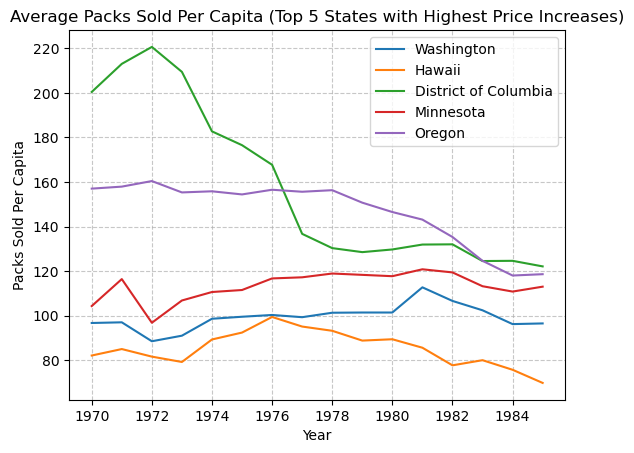

In [10]:
for state in top5_states:
    state_data = packs_per_capita[packs_per_capita['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'], label=state)

plt.title('Average Packs Sold Per Capita (Top 5 States with Highest Price Increases)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [11]:
price_change = df.groupby('state')['cost_per_pack'].agg(['first', 'last']).reset_index()

# Calculate the total increase in price
price_change['price_increase'] = price_change['last'] - price_change['first']

bottom5_states = price_change.sort_values('price_increase', ascending=True).head(5)['state']

print("5 states with the lowest cigarette price increases:")
print(bottom5_states.tolist())

bottom5_df = df[df['state'].isin(bottom5_states)]

# Group by year and state to calculate average packs sold per capita
packs_per_capita = bottom5_df.groupby(['Year', 'state'])['sales_per_capita'].mean().reset_index()

5 states with the lowest cigarette price increases:
['North Carolina', 'South Carolina', 'Kentucky', 'Tennessee', 'Maryland']


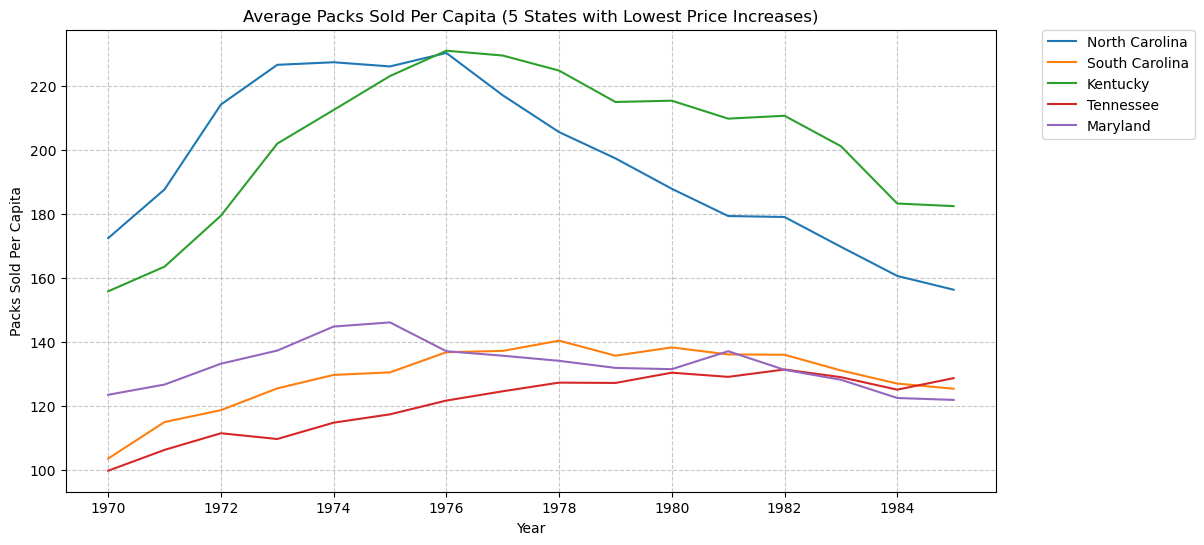

In [12]:
plt.figure(figsize=(12, 6))

for state in bottom5_states:
    state_data = packs_per_capita[packs_per_capita['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'], label=state)

plt.title('Average Packs Sold Per Capita (5 States with Lowest Price Increases)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

5. Compare the trends in sales from the 5 states with the highest price increases to those with the lowest price increases.

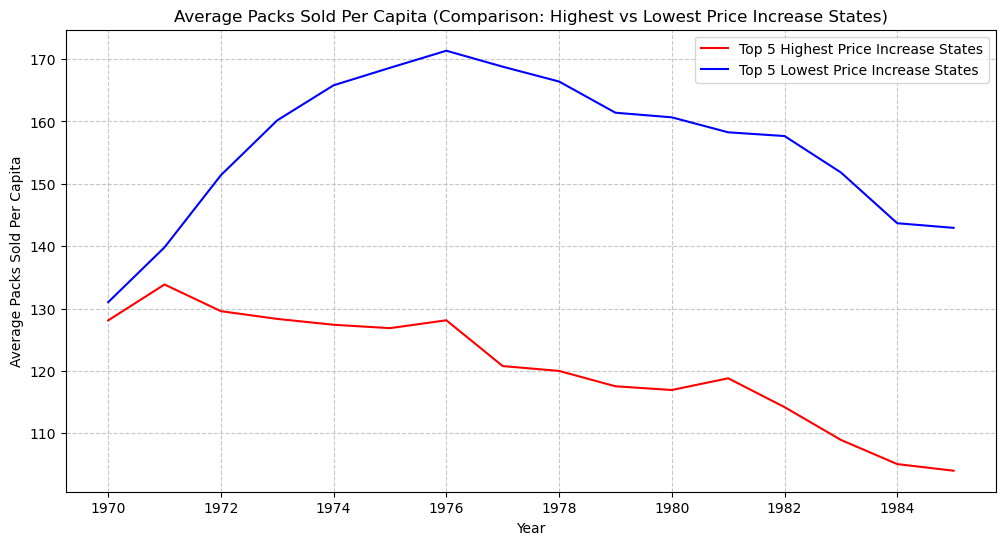

In [13]:
# Group by year and calculate mean sales_per_capita for each group (top 5 and bottom 5)

top5_avg = top5_df.groupby('Year')['sales_per_capita'].mean().reset_index()
bottom5_avg = bottom5_df.groupby('Year')['sales_per_capita'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(top5_avg['Year'], top5_avg['sales_per_capita'], label='Top 5 Highest Price Increase States', color='red')
plt.plot(bottom5_avg['Year'], bottom5_avg['sales_per_capita'], label='Top 5 Lowest Price Increase States', color='blue')

plt.title('Average Packs Sold Per Capita (Comparison: Highest vs Lowest Price Increase States)')
plt.xlabel('Year')
plt.ylabel('Average Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The five states with the largest increases in cigarette prices saw a sharp decline in packs sold per capita from 1970 to 2018, indicating the influence of higher prices and likely stricter tobacco control policies. In contrast, the five states with the smallest price increases experienced more stable cigarette consumption over time, with only a gradual decline. This suggests that states with smaller price hikes, many of which have historical ties to tobacco production, were less proactive in using price-based policies to discourage smoking.

6. Focusing only on the time period from 1970 to 1990, regress log sales on log prices to estimate the price elasticity of demand over that period. Interpret your results.